In [49]:
# load both TIFFs
# load best model
# tile image, normalize
import sys
sys.path.append('src')
from src.trainer import EuroSATTrainer
from src.load_data import get_eurosat_dataloaders

import geopandas as gpd # for reading shapefiles
import folium  # library to create interactive maps
from shapely.geometry import MultiPolygon, Polygon
import os 
import rasterio as rio
from rasterio.mask import mask
import zipfile
import rasterio
import json
import shutil
import cv2
import numpy as np
from tqdm import tqdm
import torch
from collections import Counter

# read credentials.json
with open('credentials.json') as f:
    credentials = json.load(f)

import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
best_model_path = 'bin/epoch=23-step=6767.ckpt'
model = EuroSATTrainer.load_from_checkpoint(best_model_path)

In [3]:
earliest_raster = rio.open('S2B_MSIL2A_20200505T154809_N0214_R054_T18TWL_20200505T194233.tiff').read()
latest_raster = rio.open('S2A_MSIL2A_20220825T155151_N0400_R011_T18TWL_20220825T220800.tiff').read()

In [25]:

tile = 64
img_height = latest_raster.shape[1]
img_width = latest_raster.shape[2]

num_vertical_tiles = img_height // tile
num_horizontal_tiles = img_width // tile
cropped_latest_img = latest_raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]
cropped_earliest_img = earliest_raster[:,:tile*num_vertical_tiles, :tile*num_horizontal_tiles]


In [52]:
_, _, label_dict = get_eurosat_dataloaders(batch_size = 1, limit=1, test_size = .1)

100%|██████████| 1/1 [00:00<00:00, 2434.30it/s]


In [96]:
# for loop split

def get_tiled_predictions(cropped_img):
    tiled_array = np.zeros((cropped_img.shape[1],cropped_img.shape[2]))
    model.eval();
    tile_predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, img_height-tile, tile)):
            for j in range(0, img_width-tile, tile):
                tiled_image = cropped_img[:,i:i+tile,j:j+tile]        
                if tiled_image.std() == 0:
                    tiled_array[i:i+tile,j:j+tile] = -1
                else:
                    x = torch.tensor(tiled_image.astype(np.int16))
                    x = (x - x.min()) / (x.max() - x.min())   
                    y_pred = model.forward(x.unsqueeze(0).cuda())
                    predicted_class = y_pred.argmax().cpu().item()
                    tiled_array[i:i+tile,j:j+tile] = predicted_class
                    tile_predictions.append(predicted_class)



    return tile_predictions, tiled_array, 

In [97]:
latest_tile_predictions, latest_tiled_array = get_tiled_predictions(cropped_latest_img)
earliest_tile_predictions, earliest_tiled_array = get_tiled_predictions(cropped_earliest_img)


100%|██████████| 35/35 [00:25<00:00,  1.38it/s]


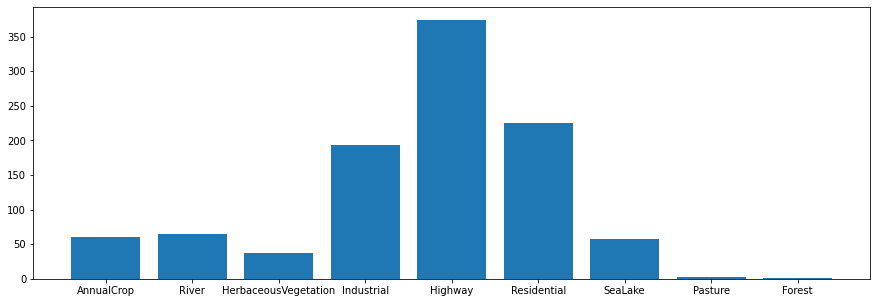

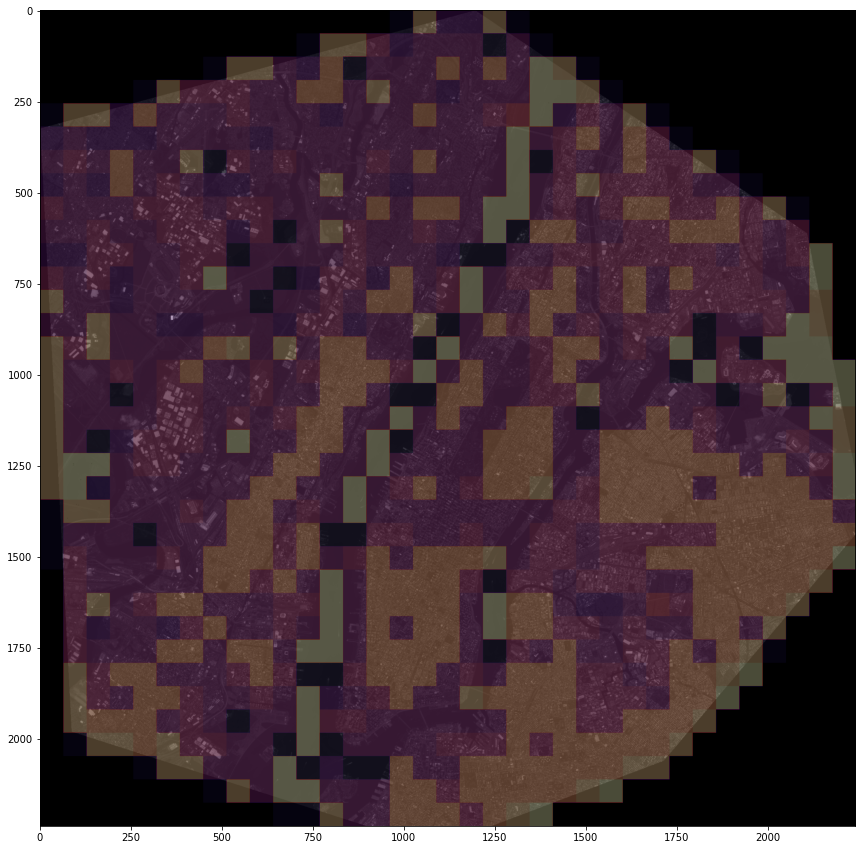

In [105]:

tile_counter = Counter(latest_tile_predictions)
latest_landmass_counts = {}
for key in tile_counter.keys():
    landmass = label_dict[key].replace('/','')
    latest_landmass_counts[landmass] = tile_counter[key]
    
plt.figure(figsize=(15,5))
names = list(latest_landmass_counts.keys())
values = list(latest_landmass_counts.values())

plt.bar(range(len(latest_landmass_counts)), values, tick_label=names)


plt.figure(figsize=(15,15))
plt.imshow(cropped_latest_img.mean(axis=0),cmap='gray')
plt.imshow(latest_tiled_array,alpha=.3,cmap='magma')


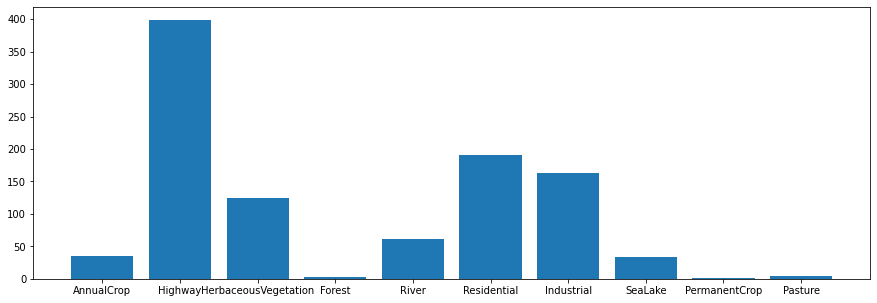

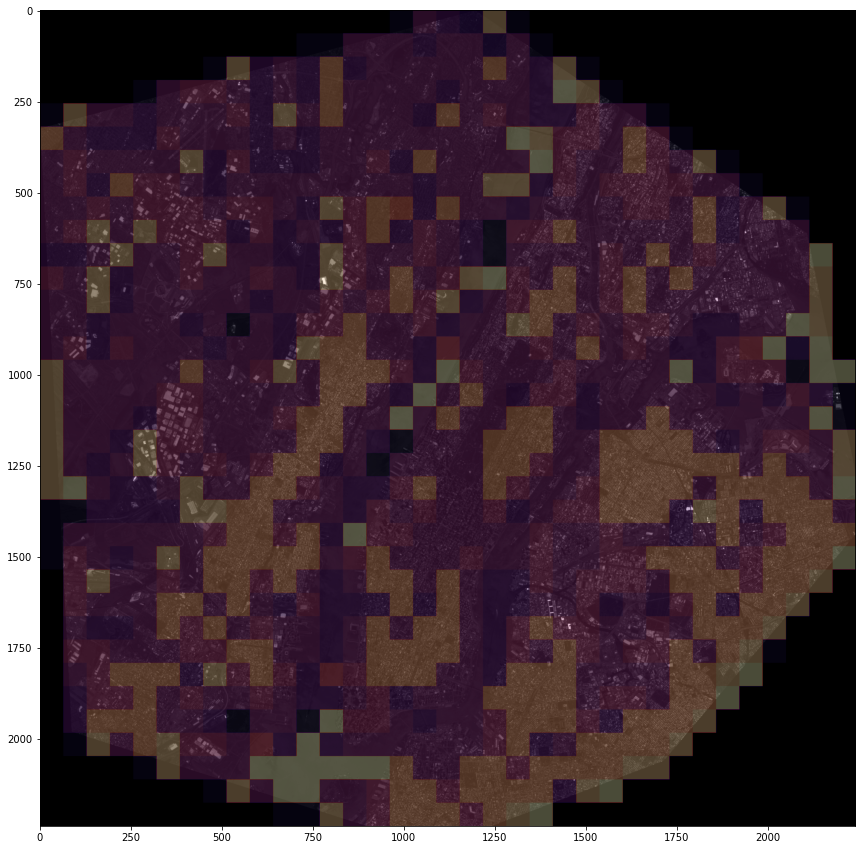

In [106]:

tile_counter = Counter(earliest_tile_predictions)
earliest_landmass_counts = {}
for key in tile_counter.keys():
    landmass = label_dict[key].replace('/','')
    earliest_landmass_counts[landmass] = tile_counter[key]
    
plt.figure(figsize=(15,5))
names = list(earliest_landmass_counts.keys())
values = list(earliest_landmass_counts.values())

plt.bar(range(len(earliest_landmass_counts)), values, tick_label=names)


plt.figure(figsize=(15,15))
plt.imshow(cropped_earliest_img.mean(axis=0),cmap='gray')
plt.imshow(earliest_tiled_array,alpha=.3,cmap='magma')


In [107]:
earliest_landmass_counts

{'AnnualCrop': 35,
 'Highway': 399,
 'HerbaceousVegetation': 125,
 'Forest': 3,
 'River': 62,
 'Residential': 191,
 'Industrial': 163,
 'SeaLake': 33,
 'PermanentCrop': 1,
 'Pasture': 4}

In [108]:
latest_landmass_counts

{'AnnualCrop': 61,
 'River': 65,
 'HerbaceousVegetation': 37,
 'Industrial': 194,
 'Highway': 374,
 'Residential': 225,
 'SeaLake': 57,
 'Pasture': 2,
 'Forest': 1}

# get percent change of each

In [110]:
pct_change_landmass = {}
for key in earliest_landmass_counts:
    if key not in latest_landmass_counts:
        pct_change_landmass[key] = None
    else:
        pct_change_landmass[key] = (latest_landmass_counts[key] - earliest_landmass_counts[key]) / earliest_landmass_counts[key]

In [111]:
pct_change_landmass

{'AnnualCrop': 0.7428571428571429,
 'Highway': -0.06265664160401002,
 'HerbaceousVegetation': -0.704,
 'Forest': -0.6666666666666666,
 'River': 0.04838709677419355,
 'Residential': 0.17801047120418848,
 'Industrial': 0.1901840490797546,
 'SeaLake': 0.7272727272727273,
 'PermanentCrop': None,
 'Pasture': -0.5}

Lowest % change for the land features you'd expect in a residential area, river, industrial, and highway

In [112]:
# biggest change was for a drop in herbaceous vegetation and forest, which make total sense when we consider that this is for two images, one in the middle of spring
# and another at the end of summer! 